## **LIBRERÍAS Y CARGA DE DATOS**

In [ ]:
from google.colab import files

# Despliega el cuadro de diálogo para subir archivos
uploaded = files.upload()

# Listar los archivos subidos (opcional)
for file_name in uploaded.keys():
    print(f'Archivo subido: {file_name}')

Saving kaggle.json to kaggle.json
Archivo subido: kaggle.json


In [ ]:
# Crea la carpeta .kaggle y mueve el archivo kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Cambia los permisos para el archivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Instala la Kaggle CLI
!pip install -q kaggle

# Descarga el dataset utilizando el identificador del nuevo dataset
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

# Descomprimir el archivo descargado
!unzip -q brian-tumor-dataset.zip -d /content/brain_tumor_dataset


Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
License(s): GPL-2.0
 99% 106M/107M [00:05<00:00, 24.9MB/s]
100% 107M/107M [00:05<00:00, 19.5MB/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns
import glob
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

In [ ]:
base_dir = '/content/brain_tumor_dataset/Brain Tumor Data Set/Brain Tumor Data Set'

## **EXPLORACIÓN Y VISUALIZACIÓN DE DATOS**

In [ ]:
pd.DataFrame(os.listdir(base_dir),columns=['Files_Name'])

Files_Name
0  Brain Tumor
1      Healthy

In [111]:
files = [i for i in glob.glob(base_dir + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Image", "Label"])
dataframe

Image        Label
0     /content/brain_tumor_dataset/Brain Tumor Data ...      Healthy
1     /content/brain_tumor_dataset/Brain Tumor Data ...  Brain Tumor
2     /content/brain_tumor_dataset/Brain Tumor Data ...  Brain Tumor
3     /content/brain_tumor_dataset/Brain Tumor Data ...      Healthy
4     /content/brain_tumor_dataset/Brain Tumor Data ...      Healthy
...                                                 ...          ...
4595  /content/brain_tumor_dataset/Brain Tumor Data ...  Brain Tumor
4596  /content/brain_tumor_dataset/Brain Tumor Data ...  Brain Tumor
4597  /content/brain_tumor_dataset/Brain Tumor Data ...  Brain Tumor
4598  /content/brain_tumor_dataset/Brain Tumor Data ...      Healthy
4599  /content/brain_tumor_dataset/Brain Tumor Data ...      Healthy

[4600 rows x 2 columns]

<ipython-input-112-c67bdabd0ea8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe["Label"], palette=palette)


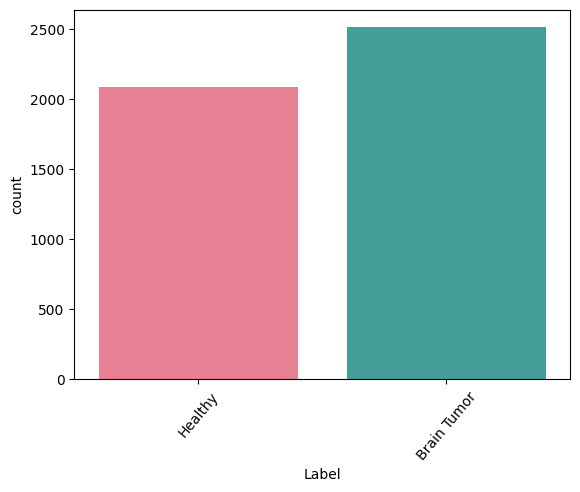

In [112]:
# Define una paleta de colores
palette = sns.color_palette("husl", len(dataframe["Label"].unique()))

# Crea el gráfico de barras con la paleta de colores
sns.countplot(x=dataframe["Label"], palette=palette)

# Rota las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=50)

# Muestra el gráfico
plt.show()

## **PREPARACIÓN DEL CONJUNTO DE DATOS DE IMÁGENES**

In [ ]:
batch_size = 32
target_size = (224,224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

Found 4514 files belonging to 2 classes.
Using 3612 files for training.
Found 4514 files belonging to 2 classes.
Using 902 files for validation.


In [ ]:
class_names = train.class_names
class_names

['Brain Tumor', 'Healthy']

## **MODELOS**

### **MODELO 1: VGG16**

In [ ]:
# Cargar el modelo VGG16 preentrenado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo base para que no se vuelvan a entrenar
for layer in base_model.layers:
    layer.trainable = False

# Crear el modelo secuencial y añadir las capas del modelo base
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Entrenar el modelo
epochs = 10
history = model.fit(train, validation_data=validation, epochs=epochs)


Epoch 1/10
113/113 [==============================] - 34s 233ms/step - loss: 1.2552 - accuracy: 0.8610 - val_loss: 0.0548 - val_accuracy: 0.9823
Epoch 2/10
113/113 [==============================] - 19s 164ms/step - loss: 0.1105 - accuracy: 0.9637 - val_loss: 0.0289 - val_accuracy: 0.9922
Epoch 3/10
113/113 [==============================] - 19s 163ms/step - loss: 0.0410 - accuracy: 0.9842 - val_loss: 0.0096 - val_accuracy: 0.9978
Epoch 4/10
113/113 [==============================] - 19s 163ms/step - loss: 0.0322 - accuracy: 0.9895 - val_loss: 0.0160 - val_accuracy: 0.9945
Epoch 5/10
113/113 [==============================] - 18s 159ms/step - loss: 0.0234 - accuracy: 0.9928 - val_loss: 0.0108 - val_accuracy: 0.9933
Epoch 6/10
113/113 [==============================] - 19s 163ms/step - loss: 0.0149 - accuracy: 0.9934 - val_loss: 0.0145 - val_accuracy: 0.9967
Epoch 7/10
113/113 [==============================] - 18s 161ms/step - loss: 0.0239 - accuracy: 0.9917 - val_loss: 0.0146 - val_ac

In [ ]:
score, acc = model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

29/29 [==============================] - 4s 122ms/step - loss: 0.0041 - accuracy: 0.9989
Test Loss = 0.004085524007678032
Test Accuracy = 0.9988913536071777


In [ ]:
hist_=pd.DataFrame(history.history)
hist_

loss  accuracy  val_loss  val_accuracy
0  1.255160  0.861019  0.054757      0.982262
1  0.110516  0.963732  0.028923      0.992239
2  0.041039  0.984219  0.009617      0.997783
3  0.032162  0.989480  0.015983      0.994457
4  0.023420  0.992802  0.010780      0.993348
5  0.014863  0.993355  0.014497      0.996674
6  0.023907  0.991694  0.014553      0.997783
7  0.008600  0.996678  0.009898      0.996674
8  0.011077  0.995293  0.011341      0.996674
9  0.006502  0.997231  0.004086      0.998891

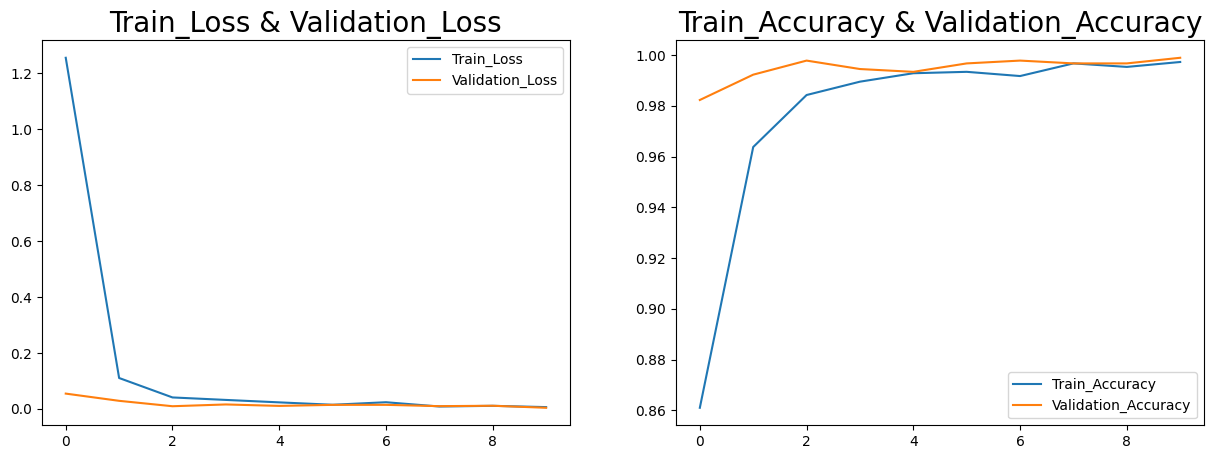

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [ ]:
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

predictions = model.predict(np.array(X_val))
y_pred = np.round(predictions).flatten()

df = pd.DataFrame({'Actual': y_val, 'Predicción': y_pred.astype(int)})
df

29/29 [==============================] - 3s 120ms/step


Actual  Predicción
0         0           0
1         1           1
2         0           0
3         1           1
4         0           0
..      ...         ...
897       0           0
898       1           1
899       0           0
900       0           0
901       1           1

[902 rows x 2 columns]

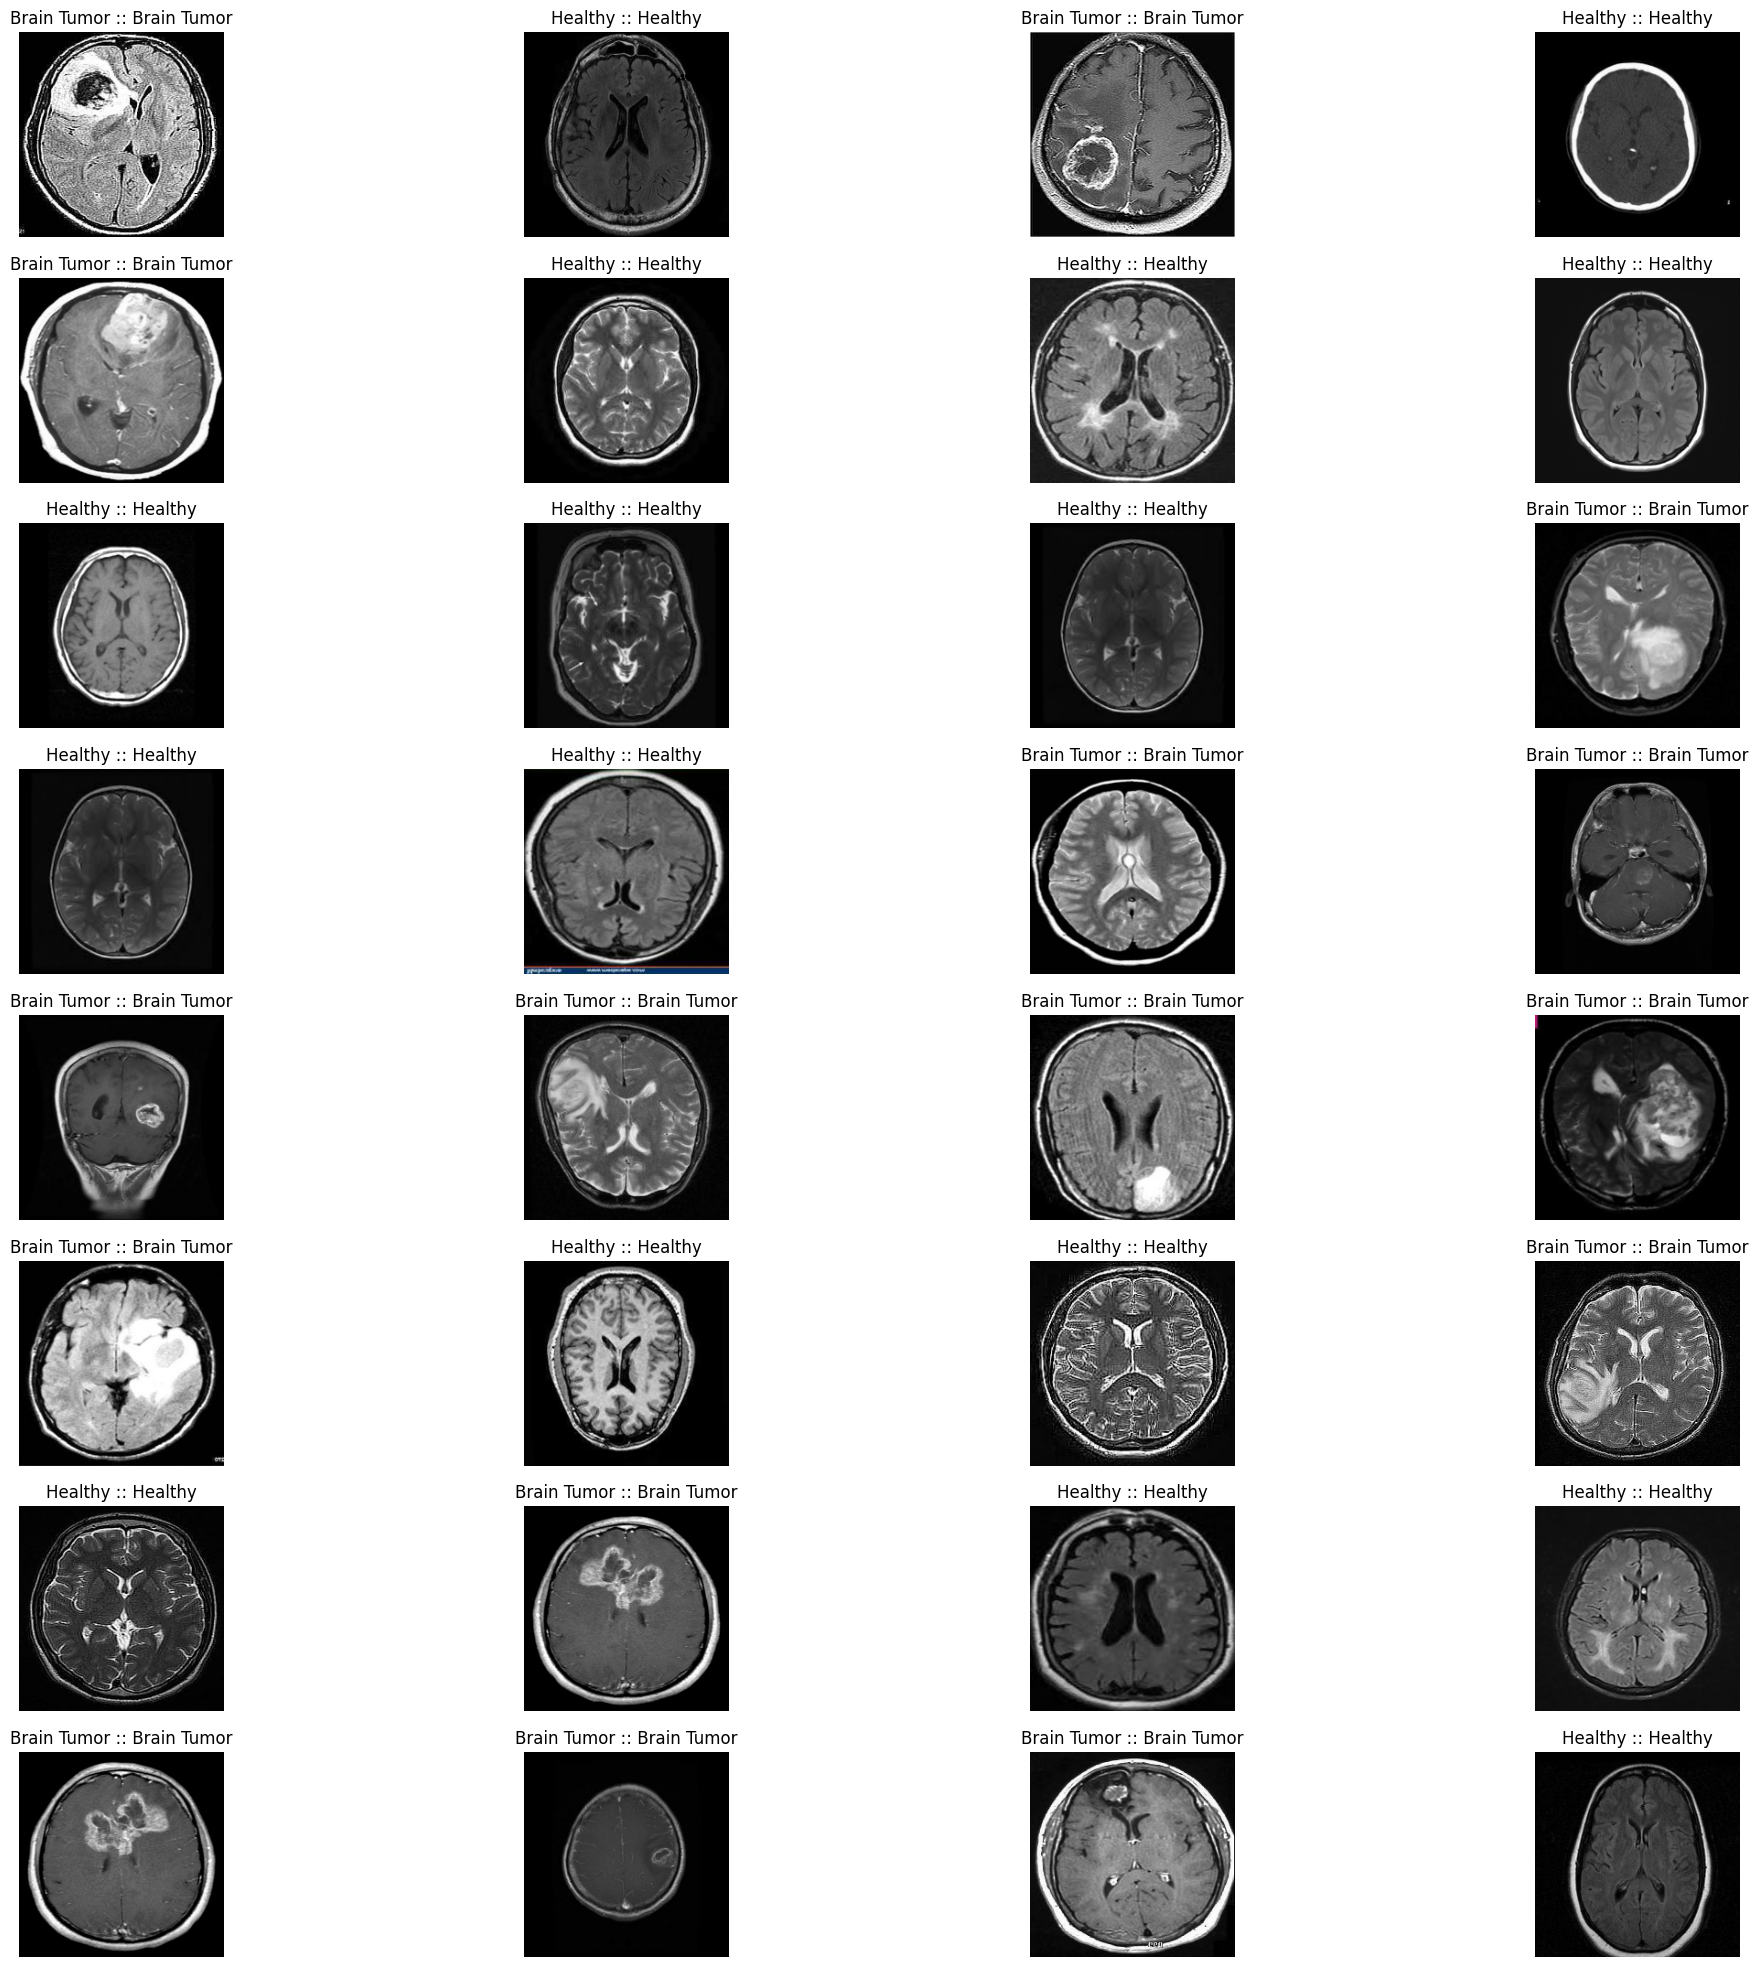

In [ ]:
# Convertir las predicciones de punto flotante a enteros
y_pred_int = y_pred.astype(int)
plt.figure(figsize=(25, 25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{train.class_names[y_val[i]]} :: {train.class_names[y_pred_int[i]]}')  # Usar las predicciones convertidas a enteros
    plt.axis("off")

plt.show()

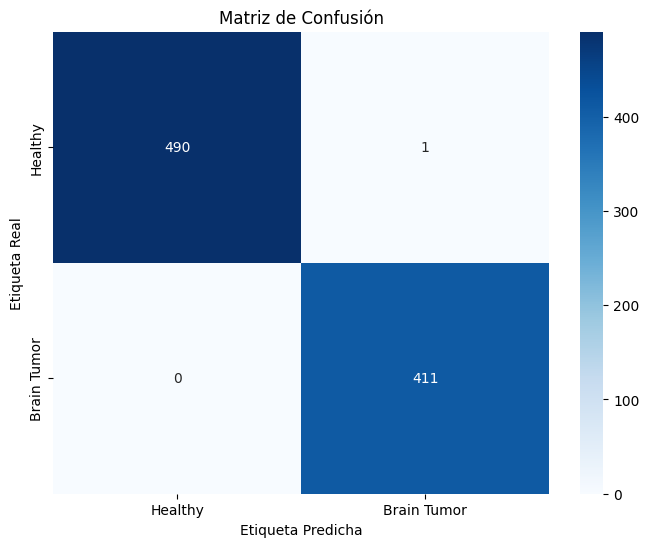

In [66]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Brain Tumor'], yticklabels=['Healthy', 'Brain Tumor'])
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

### **MODELO 2: RESNET50**

In [69]:
# Cargar el modelo ResNet50 preentrenado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo base para que no se vuelvan a entrenar
for layer in base_model.layers:
    layer.trainable = False

# Crear el modelo secuencial y añadir las capas del modelo base
model2 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [70]:
# Entrenar el modelo
epochs = 10
history2 = model2.fit(train, validation_data=validation, epochs=epochs)

Epoch 1/10
113/113 [==============================] - 20s 149ms/step - loss: 0.5158 - accuracy: 0.8840 - val_loss: 0.0366 - val_accuracy: 0.9933
Epoch 2/10
113/113 [==============================] - 17s 143ms/step - loss: 0.0686 - accuracy: 0.9762 - val_loss: 0.0204 - val_accuracy: 0.9933
Epoch 3/10
113/113 [==============================] - 17s 151ms/step - loss: 0.0422 - accuracy: 0.9859 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 4/10
113/113 [==============================] - 15s 129ms/step - loss: 0.0146 - accuracy: 0.9950 - val_loss: 0.0092 - val_accuracy: 0.9967
Epoch 5/10
113/113 [==============================] - 15s 129ms/step - loss: 0.0137 - accuracy: 0.9964 - val_loss: 0.0035 - val_accuracy: 0.9989
Epoch 6/10
113/113 [==============================] - 15s 129ms/step - loss: 0.0091 - accuracy: 0.9978 - val_loss: 0.0034 - val_accuracy: 0.9989
Epoch 7/10
113/113 [==============================] - 15s 131ms/step - loss: 0.0126 - accuracy: 0.9958 - val_loss: 0.0016 - val_ac

In [71]:
score, acc = model2.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

29/29 [==============================] - 3s 93ms/step - loss: 0.0054 - accuracy: 0.9978
Test Loss = 0.005350332707166672
Test Accuracy = 0.9977827072143555


In [72]:
hist_=pd.DataFrame(history2.history)
hist_

loss  accuracy  val_loss  val_accuracy
0  0.515849  0.883998  0.036640      0.993348
1  0.068629  0.976190  0.020386      0.993348
2  0.042190  0.985880  0.008068      1.000000
3  0.014560  0.995017  0.009151      0.996674
4  0.013675  0.996401  0.003464      0.998891
5  0.009140  0.997785  0.003367      0.998891
6  0.012624  0.995847  0.001631      1.000000
7  0.024629  0.992802  0.007308      0.998891
8  0.014132  0.995293  0.001650      1.000000
9  0.012788  0.995847  0.005350      0.997783

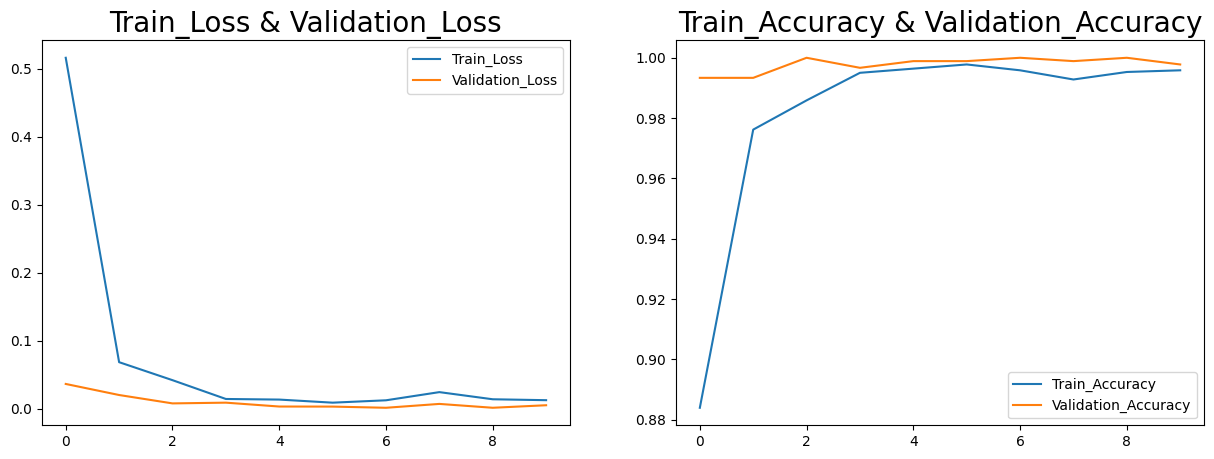

In [73]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [74]:
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

predictions = model2.predict(np.array(X_val))
y_pred = np.round(predictions).flatten()

df = pd.DataFrame({'Actual': y_val, 'Predicción': y_pred.astype(int)})
df

29/29 [==============================] - 4s 93ms/step


Actual  Predicción
0         0           0
1         0           0
2         0           0
3         0           0
4         0           0
..      ...         ...
897       1           1
898       1           1
899       0           0
900       0           0
901       1           1

[902 rows x 2 columns]

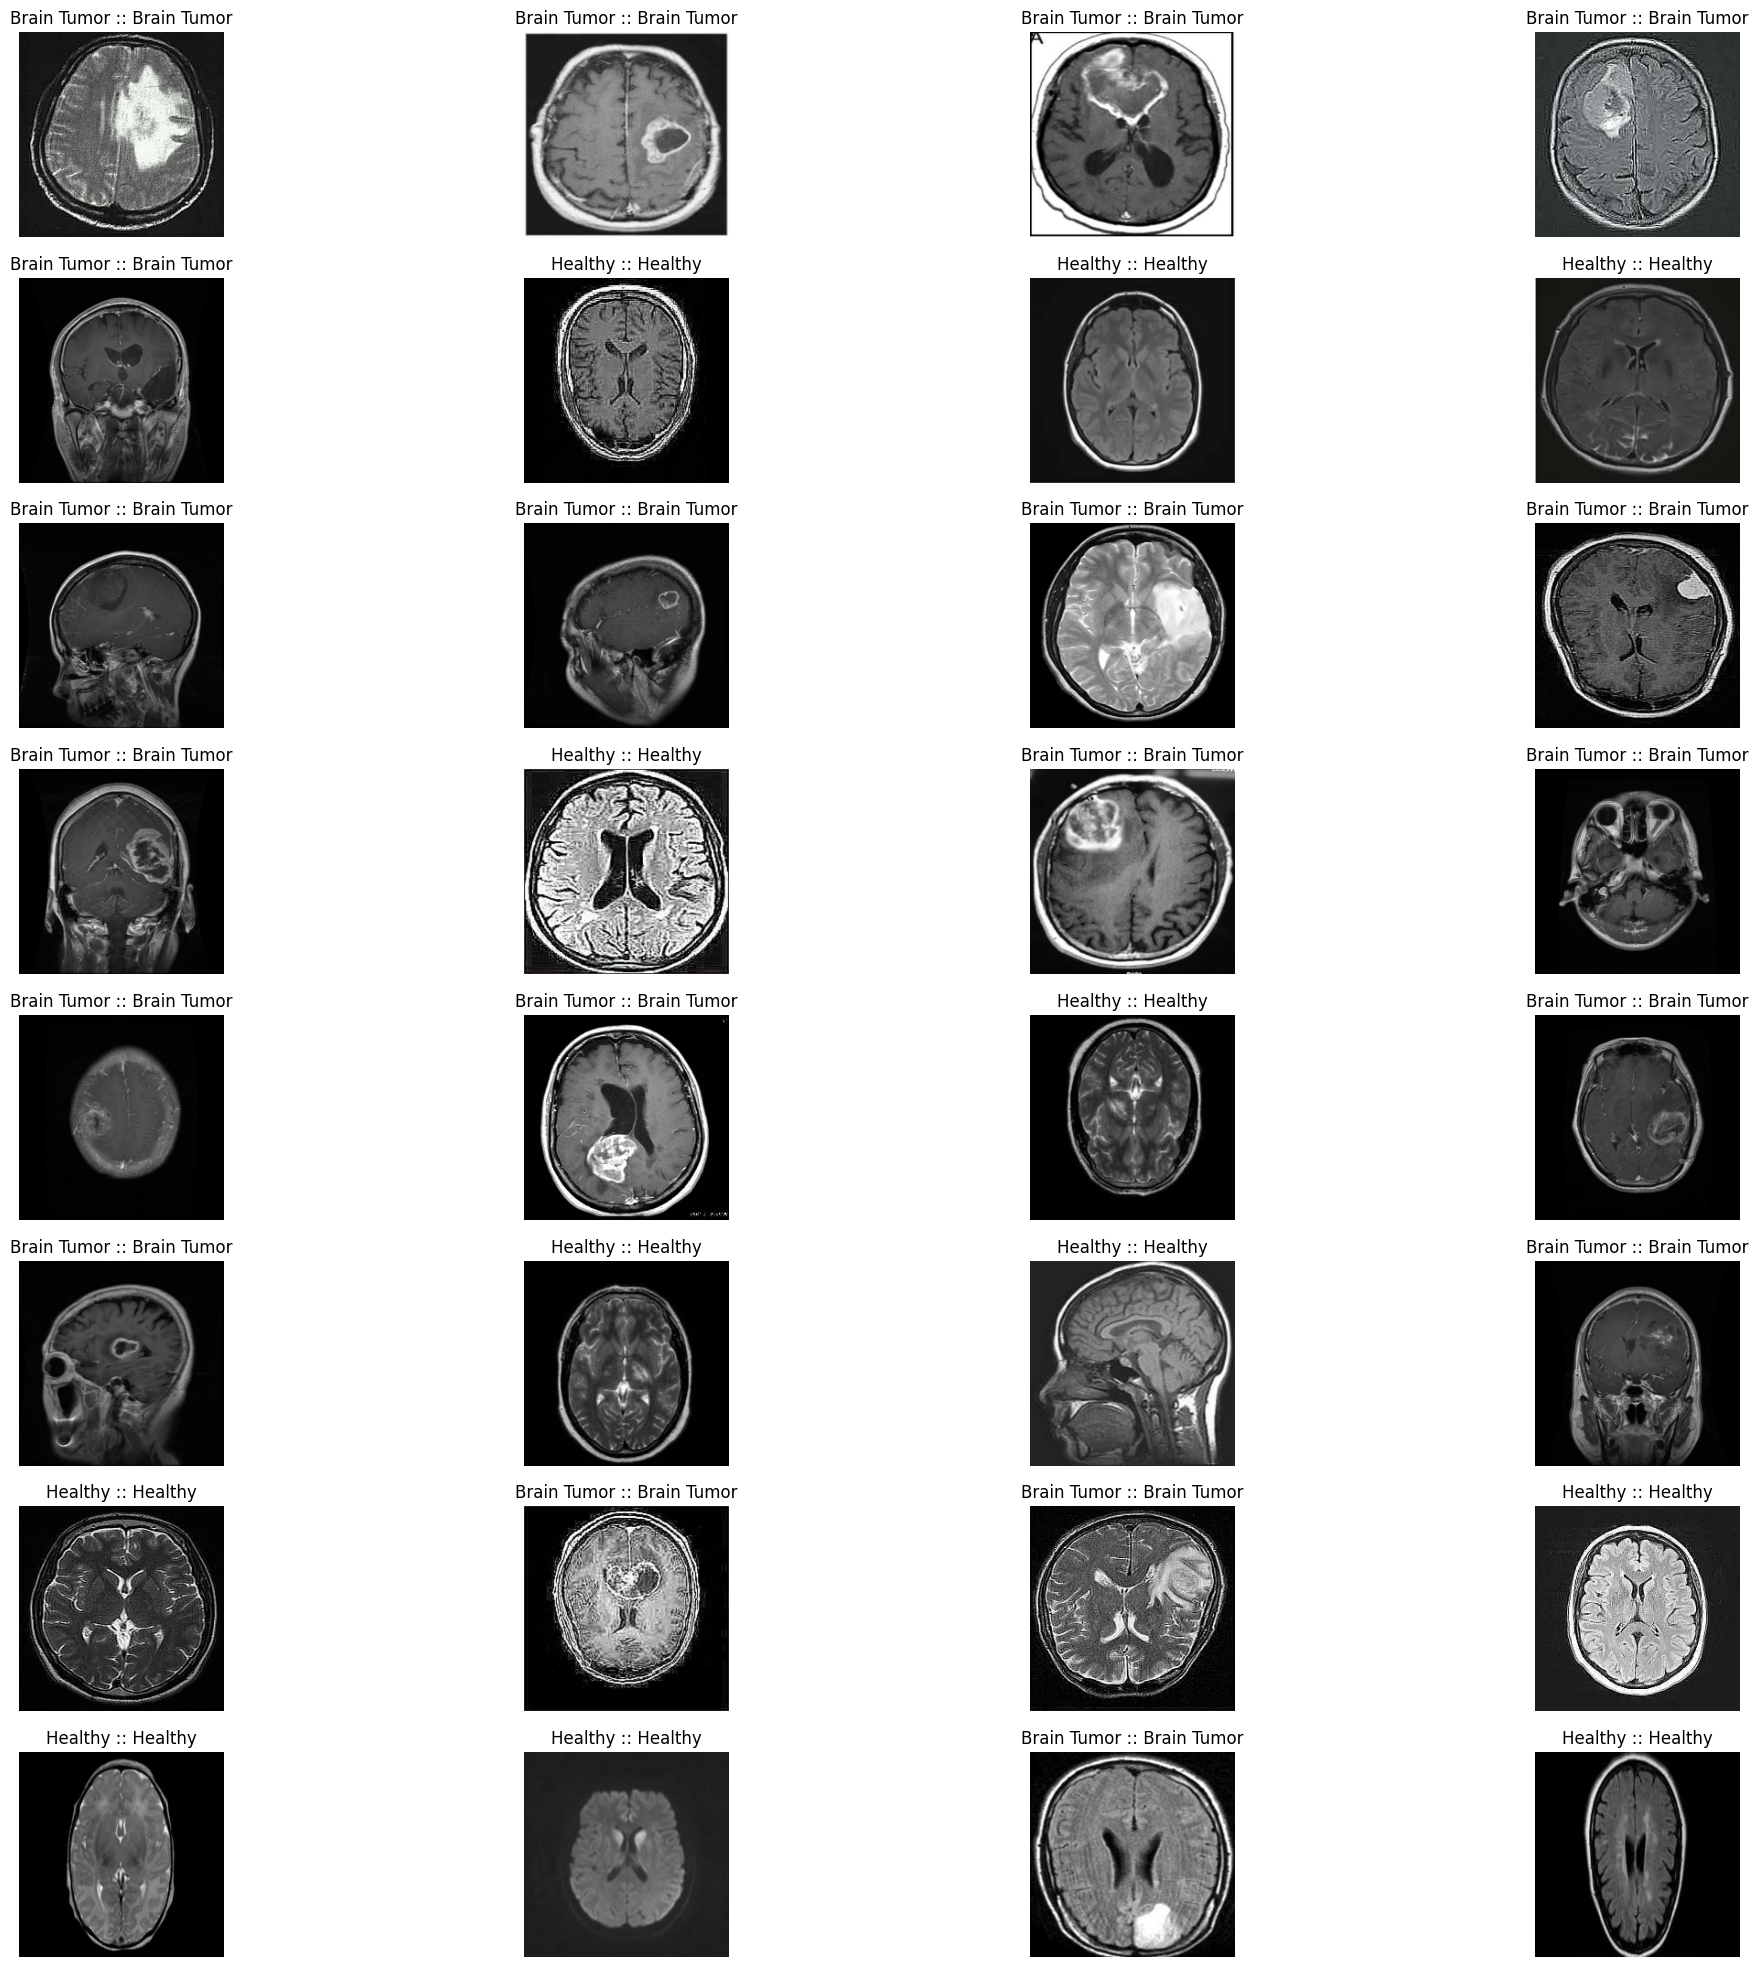

In [75]:
# Convertir las predicciones de punto flotante a enteros
y_pred_int = y_pred.astype(int)
plt.figure(figsize=(25, 25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{train.class_names[y_val[i]]} :: {train.class_names[y_pred_int[i]]}')  # Usar las predicciones convertidas a enteros
    plt.axis("off")

plt.show()

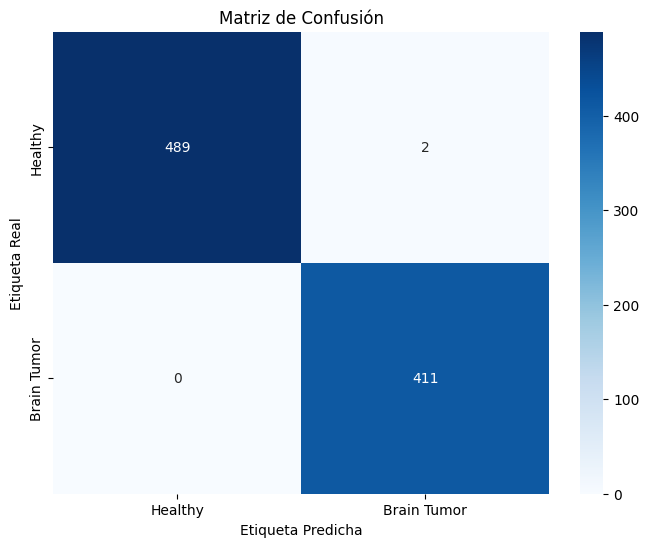

In [76]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Brain Tumor'], yticklabels=['Healthy', 'Brain Tumor'])
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

### **COMPARACIÓN DE MODELOS PRE-ENTRENADOS**

In [82]:
def compare_models(history, history2, model, model2, X_val, y_val):
    # Comparar precisión
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Modelo 1 - Precisión en Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Modelo 1 - Precisión en Validación')
    plt.plot(history2.history['accuracy'], label='Modelo 2 - Precisión en Entrenamiento')
    plt.plot(history2.history['val_accuracy'], label='Modelo 2 - Precisión en Validación')
    plt.title('Comparación de la Precisión de los Modelos')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Comparar pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Modelo 1 - Pérdida en Entrenamiento')
    plt.plot(history.history['val_loss'], label='Modelo 1 - Pérdida en Validación')
    plt.plot(history2.history['loss'], label='Modelo 2 - Pérdida en Entrenamiento')
    plt.plot(history2.history['val_loss'], label='Modelo 2 - Pérdida en Validación')
    plt.title('Comparación de la Pérdida de los Modelos')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluación en el conjunto de prueba
    score1 = model.evaluate(X_val, y_val, verbose=0)
    score2 = model2.evaluate(X_val, y_val, verbose=0)
    print(f"Modelo 1 - Pérdida: {score1[0]}, Precisión: {score1[1]}")
    print(f"Modelo 2 - Pérdida: {score2[0]}, Precisión: {score2[1]}")

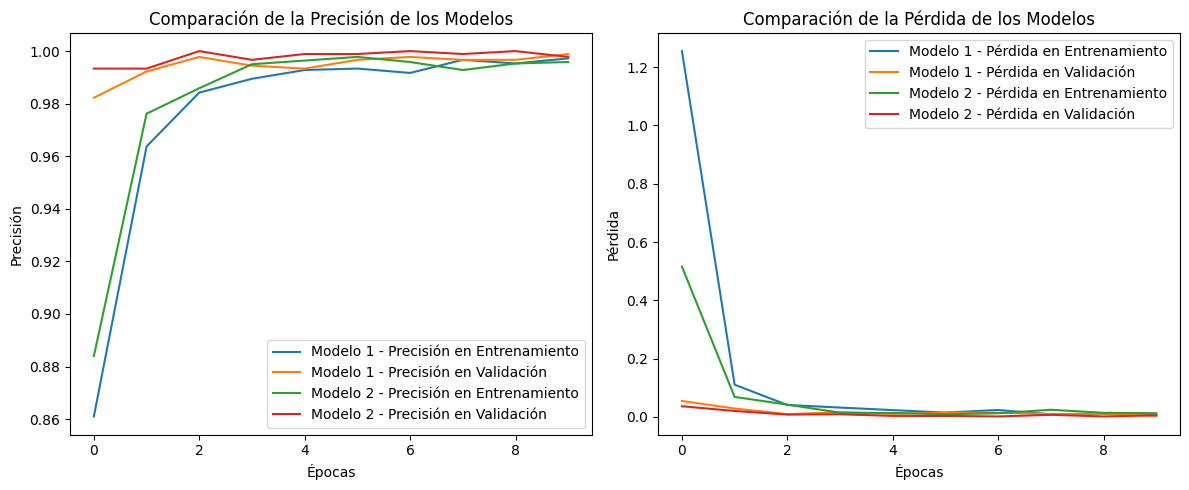

Modelo 1 - Pérdida: 0.009405683726072311, Precisión: 0.9966740608215332
Modelo 2 - Pérdida: 0.005350332707166672, Precisión: 0.9977827072143555


In [83]:
# Convertir las listas X_val y y_val en matrices numpy
X_val_np = np.array(X_val)
y_val_np = np.array(y_val)

# Comparar modelos
compare_models(history, history2, model, model2, X_val_np, y_val_np)


### **PREDICCIÓN**

In [102]:
def prepare_image(image_path):
    """Prepara una imagen para ser evaluada por el modelo CNN."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Cargar imagen en escala de grises
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convertir a imagen RGB
        img_rgb = cv2.resize(img_rgb, (224, 224))  # Redimensionar la imagen a 224x224
        img_rgb = img_rgb / 255.0  # Normalizar los valores de píxeles
        img_rgb = np.expand_dims(img_rgb, axis=0)  # Añadir una dimensión de lote
        return img_rgb
    else:
        return None


In [103]:
def predict_tumor_with_prob_model1(image_path, model):
    """Determina si la imagen contiene un tumor y devuelve la probabilidad de la predicción."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model.predict(img)
        probability = prediction[0][0]
        return ("Tumor", probability) if probability > 0.5 else ("Healthy", 1 - probability)
    else:
        return ("La imagen no se encontró o no pudo leerse", None)

1/1 [==============================] - 0s 38ms/step


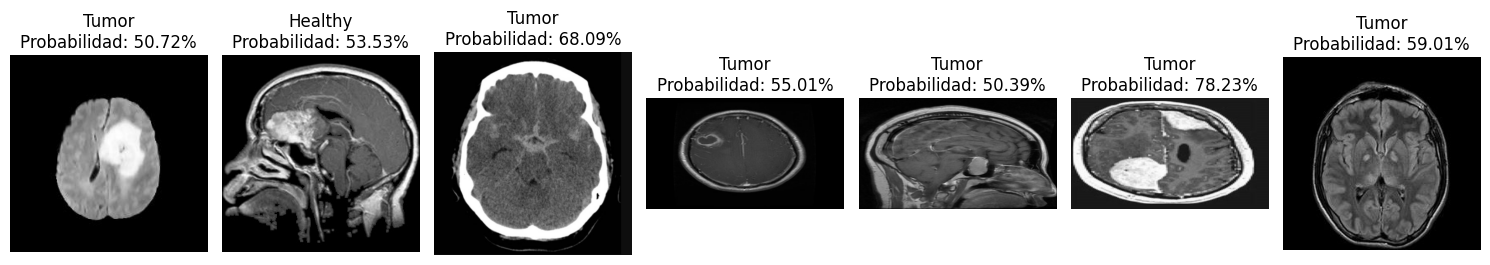

In [109]:
def plot_images_with_predictions(image_paths, model):
    """Plotea las imágenes con su clase predicha y el porcentaje correspondiente."""
    # Crear subplots
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

    # Procesar cada imagen y mostrar
    for ax, image_path in zip(axes, image_paths):
        # Preparar la imagen y realizar la predicción
        label, probability = predict_tumor_with_prob_model1(image_path, model)

        # Mostrar la imagen y la predicción
        img = cv2.imread(image_path)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB
        ax.title.set_text(f'{label}\nProbabilidad: {probability:.2%}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Rutas de las imágenes
image_paths = [
    '/content/PRUEBA CANCER O NO.png',
    '/content/PRUEBA CANCER O NO 1.png',
    '/content/PRUEBA CANCER O NO 2.png',
    '/content/PRUEBA GL.png',
    '/content/PRUEBA PI.png',
    '/content/PRUEBA MEN.png',
    '/content/PRUEBA NO CANCER.png'
]

# Utilizar la función para plotear las imágenes con sus predicciones
plot_images_with_predictions(image_paths, model)


In [105]:
def predict_tumor_with_prob_model2(image_path, model):
    """Determina si la imagen contiene un tumor y devuelve la probabilidad de la predicción."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model2.predict(img)
        probability = prediction[0][0]
        return ("Tumor", probability) if probability > 0.5 else ("Healthy", 1 - probability)
    else:
        return ("La imagen no se encontró o no pudo leerse", None)

1/1 [==============================] - 0s 53ms/step


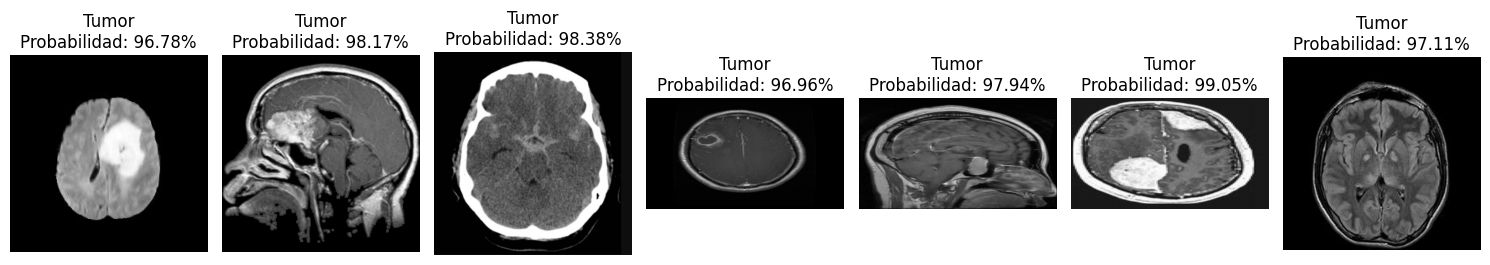

In [107]:
def plot_images_with_predictions(image_paths, model2):
    """Plotea las imágenes con su clase predicha y el porcentaje correspondiente."""
    # Crear subplots
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

    # Procesar cada imagen y mostrar
    for ax, image_path in zip(axes, image_paths):
        # Preparar la imagen y realizar la predicción
        label, probability = predict_tumor_with_prob_model2(image_path, model2)

        # Mostrar la imagen y la predicción
        img = cv2.imread(image_path)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB
        ax.title.set_text(f'{label}\nProbabilidad: {probability:.2%}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Rutas de las imágenes
image_paths = [
    '/content/PRUEBA CANCER O NO.png',
    '/content/PRUEBA CANCER O NO 1.png',
    '/content/PRUEBA CANCER O NO 2.png',
    '/content/PRUEBA GL.png',
    '/content/PRUEBA PI.png',
    '/content/PRUEBA MEN.png',
    '/content/PRUEBA NO CANCER.png'
]

# Utilizar la función para plotear las imágenes con sus predicciones
plot_images_with_predictions(image_paths, model2)
